**Deadline**: 30.10.2024 19:00 (GMT+3)

## Part I: Implement 2048 environment (6 points)

In this homework our goal is implement and solve [2048 game](https://en.wikipedia.org/wiki/2048_(video_game)). If you are not familiar with it, it's highly recommended to play some games (e.g. [here](https://2048game.com/)).

One of the most interesting question that you probably will ask yourself during solving this task is "How to design reward function here?". You can use the [reward function from the origin game](https://en.wikipedia.org/wiki/2048_(video_game)#:~:text=The%20user's%20score%20starts%20at,that%20to%20reach%20higher%20scores.) or you can use it as inspiration for developing your own reward function. Think about what is "good" reward function in this context. 

Implementation **must be consistent** with gymnasium interfaces. Keep in mind that all tests passed is requirement for achiving non-zero score for this task.

Below you can find tests that may help you with implementation.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from env import Game2048Env
import gymnasium as gym
from gymnasium import spaces

In [2]:
env = Game2048Env(render_mode='ansi')
print(env.render())

Score: 0
Highest: 2
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 2]]



In [3]:
test_left = np.array([[2, 0, 2, 4], [2, 2, 2, 2], [4, 8, 0, 16], [8, 16, 4, 0]])
answer = np.array([[4, 4, 0, 0], [4, 4, 0, 0], [4, 8, 16, 0], [8, 16, 4, 0]])

env.set_board(test_left)
score = env.move(3)
assert np.allclose(env.get_board(), answer)
assert np.allclose(score, 12)

## Part II: Implement CEM (4 points)

In this task, your goal is to train the CEM algorithm to solve your own environment. Try any tricks you learned in the webinars. You will solve the task if your solution can reach 1024 as a max tile.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from IPython.display import clear_output
import matplotlib.pyplot as plt


agent = ActionPredictor()


def extract_channels(matrix, grid_size=4):
    layers = []
    for idx in range(1, 11):
        temp_grid = np.zeros((grid_size, grid_size))
        temp_grid[np.where(matrix == 2 ** idx)] = 1
        layers.append(temp_grid)
    return torch.Tensor(np.array(layers))

class ActionPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer1 = nn.Conv2d(10, 256, kernel_size=3, padding=1)
        self.conv_layer2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv_layer3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv_layer4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dense_layer1 = nn.Linear(2048 * 2, 256)
        self.dense_layer2 = nn.Linear(256, 4)
        self.output_softmax = nn.Softmax(dim=1)
    
    def forward(self, x_input):
        x = self.conv_layer1(x_input)
        x = self.conv_layer2(x)
        x = self.conv_layer3(x)
        x = self.conv_layer4(x)
        x = torch.flatten(x, 1)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        x = self.output_softmax(x)
        return x

In [9]:
num_actions = env.action_space.n

def simulate_session(max_steps=100, epsilon=0.8):
    reward_total = 0
    state_sequence, action_sequence = [], []
    current_state = torch.Tensor(env.reset())
    with torch.no_grad():
        for step in range(max_steps):
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)
            else:
                probs = agent(extract_channels(current_state).reshape(1, 10, 4, 4))
                action = np.random.choice(num_actions, p=probs.flatten().numpy())
            next_state, reward, done, truncated, info = env.step(action)
            current_state = torch.Tensor(next_state)
            state_sequence.append(current_state)
            action_sequence.append(action)
            reward_total += reward
            if done:
                break
    return state_sequence, action_sequence, reward_total

def filter_top_sessions(state_batches, action_batches, reward_batches, percentile):
    threshold = np.percentile(reward_batches, percentile)
    elite_mask = reward_batches >= threshold
    state_batches = np.asarray(state_batches, dtype="object")
    action_batches = np.asarray(action_batches, dtype="object")
    return np.concatenate(state_batches[elite_mask]), np.concatenate(action_batches[elite_mask])


optimizer = optim.Adam(agent.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

def training_cycle(agent):
    loss_fn = nn.CrossEntropyLoss()
    def train_step(states, actions):
        states = torch.stack(tuple(extract_channels(state) for state in states))
        actions = torch.LongTensor(actions)
        optimizer.zero_grad()
        predictions = agent(states)
        loss_value = loss_fn(predictions, actions)
        entropy = -torch.sum(predictions * torch.log(predictions + 1e-8))
        total_loss = loss_value - 0.01 * entropy
        total_loss.backward()
        optimizer.step()
    return train_step

def display_progress(reward_batches, log_data, threshold_percentile, reward_range=[-990, +10]):
    avg_reward = np.mean(reward_batches)
    threshold_value = np.percentile(reward_batches, threshold_percentile)
    log_data.append([avg_reward, threshold_value])

    clear_output(True)
    print("avg reward = %.3f, threshold=%.3f" % (avg_reward, threshold_value))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log_data))[0], label='avg reward')
    plt.plot(list(zip(*log_data))[1], label='threshold')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(reward_batches, range=reward_range)
    plt.vlines([threshold_value], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

sample_a = np.random.rand(4, 4)
sample_b = sample_a
if np.all(np.isclose(sample_a, sample_b)):
    print(1)

1


In [10]:
def scale_rewards(rewards):
    rewards = np.array(rewards)
    return (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)

avg reward = 51.760, threshold=88.800


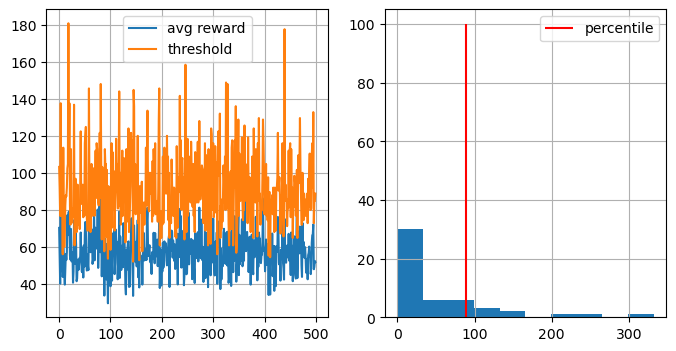

In [12]:
test_matrix = np.array([[ 2,  2,  8, 16], [ 4,  0,  4,  8], [ 0,  0,  0,  8], [ 0,  0,  0,  0]])

env.set_board(test_matrix)
print(env.get_board())
score = env.move(1)
print(env.get_board())

num_sessions = 50
percentile_value = 80
progress_log = []

train_fn = training_cycle(agent)

for iteration in range(500):
    session_data = [simulate_session() for _ in range(num_sessions)]
    state_batches, action_batches, reward_batches = zip(*session_data)
    elite_states, elite_actions = filter_top_sessions(state_batches, action_batches, reward_batches, percentile_value)
    train_fn(elite_states, elite_actions)
    scheduler.step()
    display_progress(reward_batches, progress_log, percentile_value, reward_range=[0, np.max(reward_batches)])

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

def extract_channels(matrix, grid_size=4):
    layers = np.zeros((10, grid_size, grid_size))
    for idx in range(1, 11):
        layers[idx - 1][matrix == 2 ** idx] = 1
    return torch.tensor(layers, dtype=torch.float32)

class ActionPredictor(nn.Module):
    def __init__(self):
        super(ActionPredictor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(10, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x_input):
        x = self.conv_layers(x_input)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

agent = ActionPredictor()
optimizer = optim.Adam(agent.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

def simulate_session(env, agent, max_steps=100, epsilon=0.8):
    total_reward = 0
    state_sequence, action_sequence = [], []
    current_state = env.reset()
    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = extract_channels(current_state).unsqueeze(0)
                probs = agent(state_tensor).numpy().flatten()
            action = np.random.choice(len(probs), p=probs)
        # Adjust this line based on your environment's step method
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, done, truncated, info = result
        else:
            next_state, reward, done, info = result
        state_sequence.append(current_state)
        action_sequence.append(action)
        total_reward += reward
        current_state = next_state
        if done:
            break
    return state_sequence, action_sequence, total_reward



def filter_top_sessions(state_batches, action_batches, reward_batches, percentile):
    threshold = np.percentile(reward_batches, percentile)
    elite_indices = [i for i, r in enumerate(reward_batches) if r >= threshold]
    elite_states = [state_batches[i] for i in elite_indices]
    elite_actions = [action_batches[i] for i in elite_indices]
    return np.concatenate(elite_states), np.concatenate(elite_actions)

def train_step(states, actions):
    agent.train()
    state_tensors = torch.stack([extract_channels(s) for s in states])
    action_tensors = torch.tensor(actions, dtype=torch.long)
    optimizer.zero_grad()
    predictions = agent(state_tensors)
    loss = loss_fn(predictions, action_tensors)
    entropy = -torch.sum(predictions * torch.log(predictions + 1e-8))
    total_loss = loss - 0.01 * entropy
    total_loss.backward()
    optimizer.step()

avg reward = 47.120, threshold = 80.800


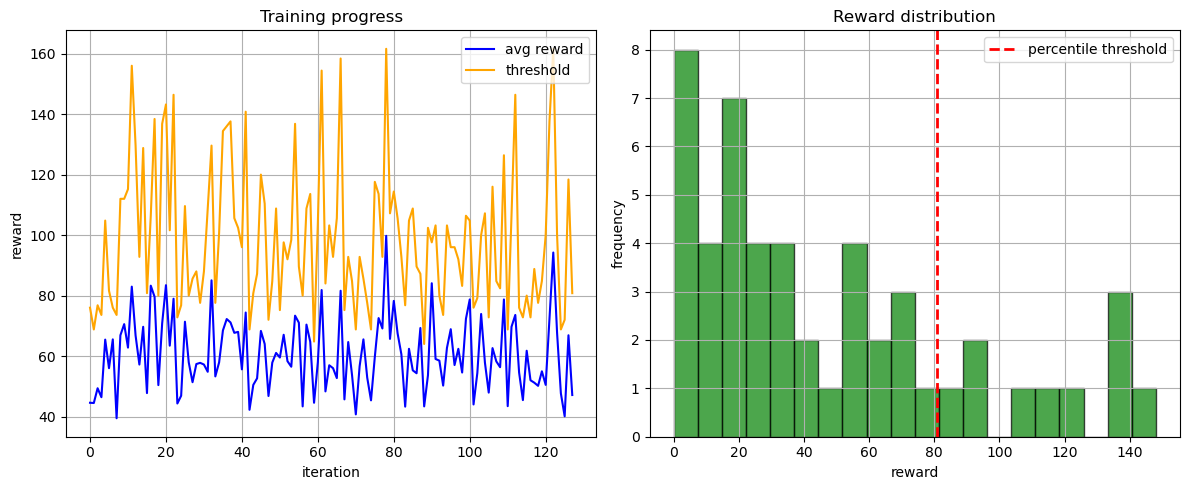

In [ ]:
def display_progress(reward_batches, log_data, threshold_percentile, reward_range=[-990, +10]):
    avg_reward = np.mean(reward_batches)
    threshold_value = np.percentile(reward_batches, threshold_percentile)
    log_data.append([avg_reward, threshold_value])

    clear_output(wait=True)
    print(f"avg reward = {avg_reward:.3f}, threshold = {threshold_value:.3f}")
    plt.figure(figsize=[12, 5])

    plt.subplot(1, 2, 1)
    plt.plot([log[0] for log in log_data], label='avg reward', color='blue')
    plt.plot([log[1] for log in log_data], label='threshold', color='orange')
    plt.xlabel('iteration')
    plt.ylabel('reward')
    plt.title('Training progress')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(reward_batches, bins=20, range=reward_range, color='green', edgecolor='black', alpha=0.7)
    plt.axvline(threshold_value, color='red', linestyle='dashed', linewidth=2, label='percentile threshold')
    plt.xlabel('reward')
    plt.ylabel('frequency')
    plt.title('Reward distribution')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

test_matrix = np.array([
    [2, 2, 8, 16],
    [4, 0, 4, 8],
    [0, 0, 0, 8],
    [0, 0, 0, 0]
])

env.set_board(test_matrix)
score = env.move(1)

num_sessions = 50
percentile_value = 80
progress_log = []

def train_step(states, actions):
    agent.train()
    state_tensors = torch.stack([extract_channels(s) for s in states])
    action_tensors = torch.tensor(actions, dtype=torch.long)
    optimizer.zero_grad()
    predictions = agent(state_tensors)
    loss = loss_fn(predictions, action_tensors)
    entropy = -torch.sum(predictions * torch.log(predictions + 1e-8))
    total_loss = loss - 0.01 * entropy
    total_loss.backward()
    optimizer.step()

for iteration in range(500):
    session_data = [simulate_session(env, agent) for _ in range(num_sessions)]
    state_batches, action_batches, reward_batches = zip(*session_data)
    elite_states, elite_actions = filter_top_sessions(
        state_batches, action_batches, reward_batches, percentile_value)
    train_step(elite_states, elite_actions)
    scheduler.step()
    display_progress(reward_batches, progress_log, percentile_value,
                     reward_range=[0, np.max(reward_batches)])
